In [1]:
import numpy as np
import matplotlib.pyplot as plt
import multiprocess as mp
import glob
import time
from tqdm import tqdm
import os
import sys
import pandas as pd
from eumap.misc import find_files, ttprint
from eumap.raster import read_rasters, save_rasters
from eumap.mapper import SpaceOverlay
import geopandas as gpd
from pathlib import Path
import rasterio
import pyproj
from shapely.geometry import Point
from eumap.mapper import LandMapper
from scipy.special import expit, logit

import warnings

import matplotlib
import matplotlib.pyplot as plt

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, cross_val_score, HalvingGridSearchCV, KFold, GroupKFold, cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import StackingRegressor

import joblib
import pickle
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer
from tool_kit import calc_ccc
from kneed import KneeLocator
from benchmark_pipeline import read_features, run_cumusort, parameter_fine_tuning, read_features, calc_metrics, run_benchmark


prop_list = ['ph_cacl2','ph_h2o','oc','bulk_density','N','caco3','K','EC','P','CEC'] #
space_list = ['normal','normal','log1p','normal','log1p','log1p','log1p','log1p','log1p','log1p'] # 
filt_list = [5,5,5,5,5,5,5,5,5,5,5,5,5] #5,5,5,5,

### Plot

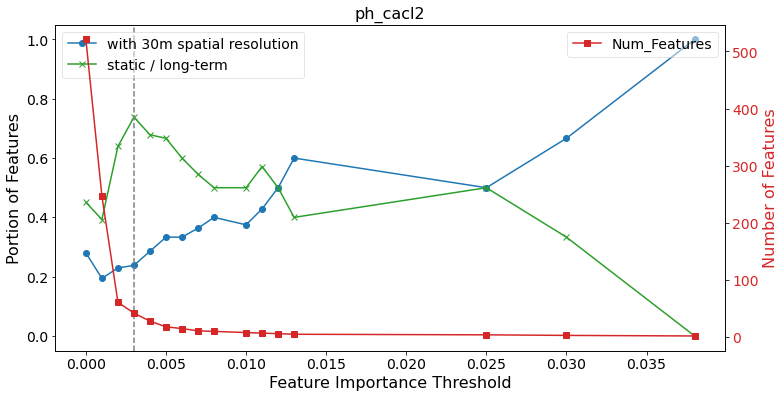

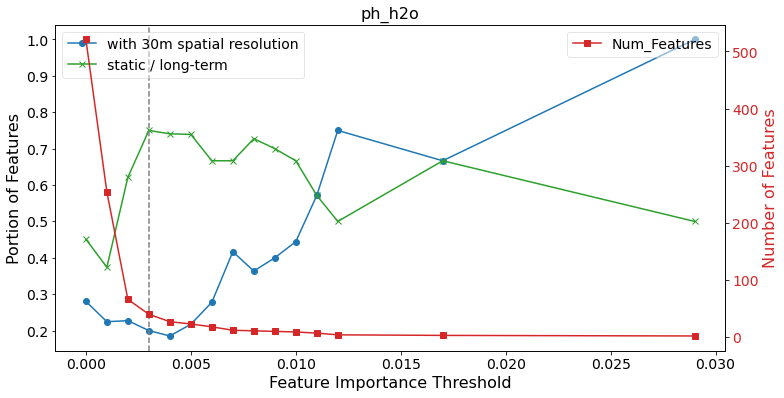

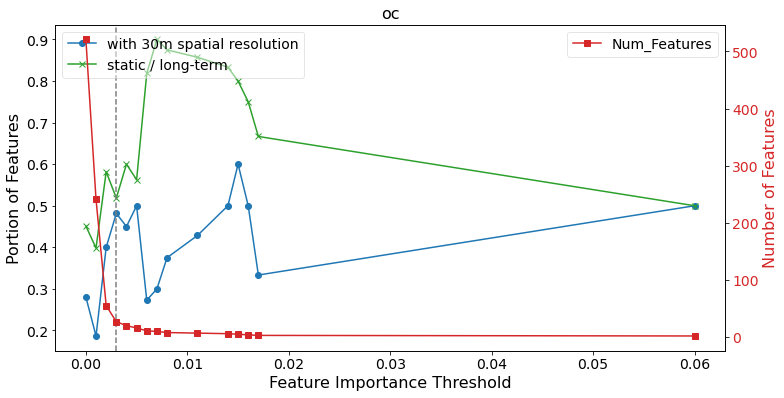

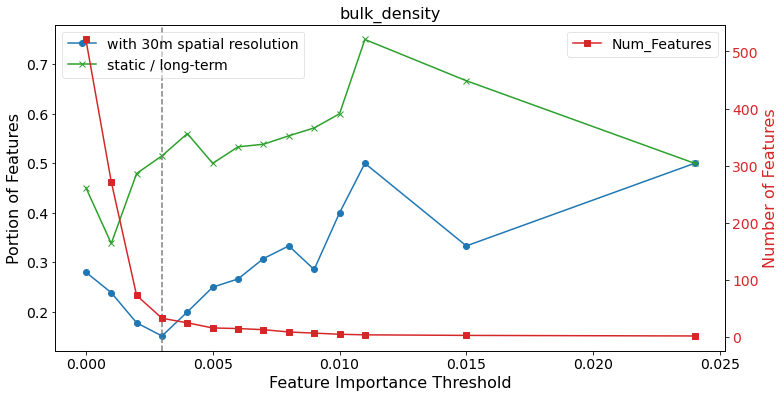

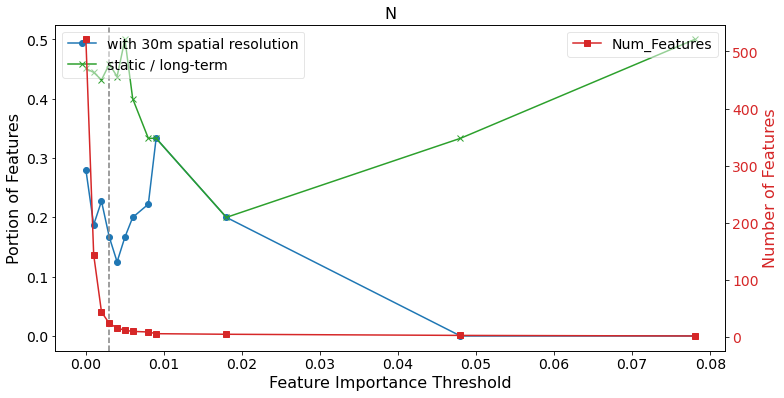

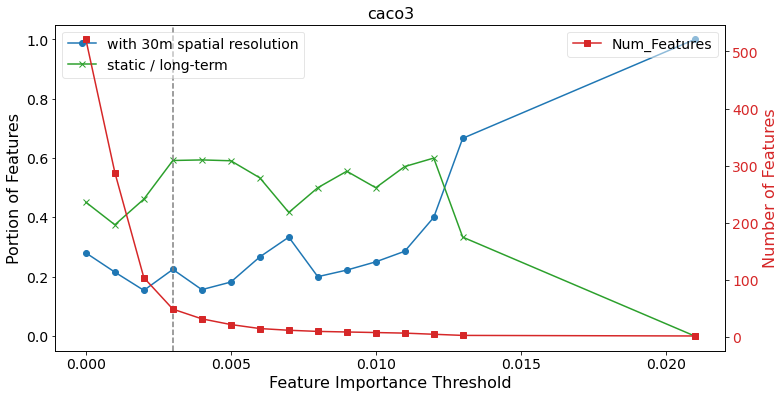

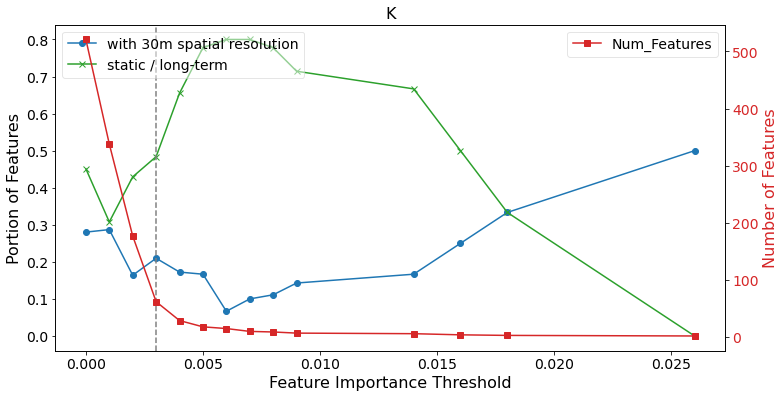

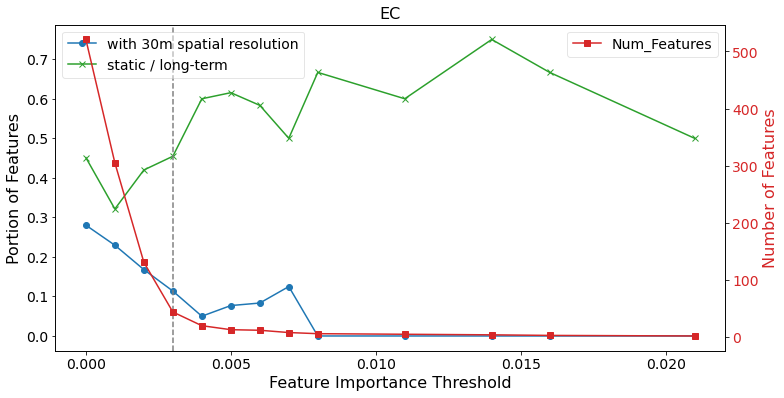

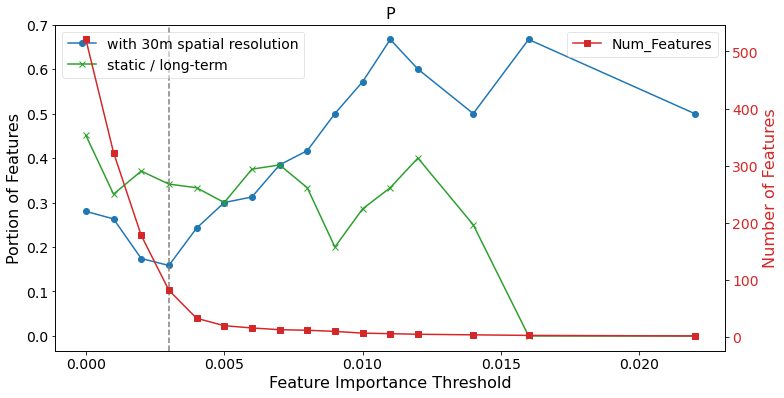

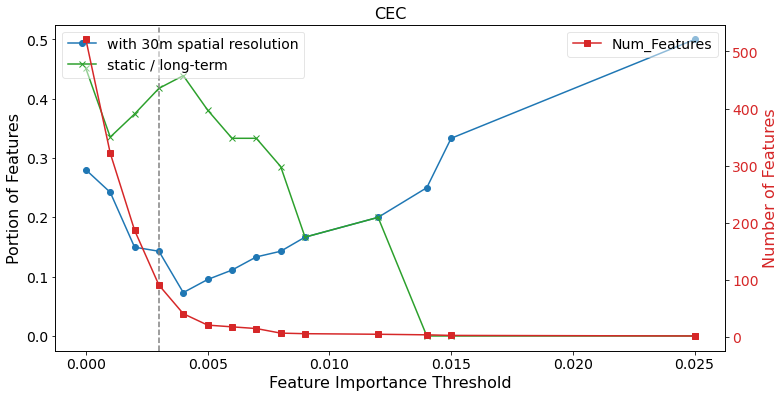

In [16]:
# read in data
for prop in prop_list:
    tep = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/{prop}/metrics_20runs.feature.elimination_{prop}.csv')

#     # Plot
#     fig, ax1 = plt.subplots(figsize=(11, 6))
#     color = 'tab:blue'
#     ax1.set_xlabel('Feature Importance Threshold', fontsize=16)
#     ax1.set_ylabel('Number of Features', color=color, fontsize=16)
#     line1 = ax1.plot(tep['Threshold'], tep['Num_Features'], color=color, marker='o', label='Num_Feat')
#     ax1.tick_params(axis='y', labelcolor=color, labelsize=14)
#     ax1.tick_params(axis='x', labelsize=14)

#     ax2 = ax1.twinx()
#     color = 'tab:red'
#     ax2.set_ylabel('Evaluation Metrics', color=color, fontsize=16)
#     line2 = ax2.plot(tep['Threshold'], tep['CCC'], color='tab:green', marker='x', label='CCC')
#     line3 = ax2.plot(tep['Threshold'], tep['RMSE'], color='tab:orange', marker='^', label='RMSE')
#     line4 = ax2.plot(tep['Threshold'], tep['R2'], color='tab:red', marker='s', label='R2')
#     ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

#     fig.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to avoid cutting off the title

#     # Combine legends
#     lines = line1 + line2 + line3 + line4
#     labels = [l.get_label() for l in lines]
#     ax1.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.15, 0.95), fontsize=14, framealpha=0.5)

#     # Best combined rank
#     best_combined_rank_index = tep['Combined_Rank'].idxmin()
#     best_threshold = tep.loc[best_combined_rank_index, 'Threshold']
#     best_num_features = tep.loc[best_combined_rank_index, 'Num_Features']

#     # Vertical line for the best threshold
#     ax1.axvline(x=best_threshold, color='grey', linestyle='--', label='Best Threshold')
    
#     # Update the legend to include the vertical line label
#     lines += [ax1.axvline(x=best_threshold, color='grey', linestyle='--')]
#     labels += ['Best Threshold']
#     ax1.legend(lines, labels, loc='upper right', fontsize=14, framealpha=0.5)#, bbox_to_anchor=(0.15, 0.95)

#     plt.title(f'{prop}, {best_num_features} features', fontsize=16)
#     # plt.savefig(f'plot_feature_elimination_{prop}.pdf', bbox_inches='tight')
#     plt.show()

    
    # Plot portion of features
    fig, ax1 = plt.subplots(figsize=(12, 6))
    ax1.set_xlabel('Feature Importance Threshold', fontsize=16)
    ax1.set_ylabel('Portion of Features', fontsize=16)
    ax1.plot(tep['Threshold'], tep['portion.features_30m'], color='tab:blue', marker='o', label='with 30m spatial resolution')
    ax1.plot(tep['Threshold'], tep['portion.features_static'], color='tab:green', marker='x', label='static / long-term')
    ax1.tick_params(axis='y', labelsize=14)
    ax1.tick_params(axis='x', labelsize=14)

    # Add secondary y-axis for number of features
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Number of Features', color=color, fontsize=16)
    ax2.plot(tep['Threshold'], tep['Num_Features'], color=color, marker='s', label='Num_Features')
    ax2.tick_params(axis='y', labelcolor=color, labelsize=14)

    # Adjust legend positions with transparency
    legend1 = ax1.legend(loc='upper left', fontsize=14)
    legend1.get_frame().set_alpha(0.5)  # Set transparency
    legend2 = ax2.legend(loc='upper right', fontsize=14)
    legend2.get_frame().set_alpha(0.5)  # Set transparency

    # Plot vertical line at the best combined rank in the second plot
    ax1.axvline(x=best_threshold, color='grey', linestyle='--')

    plt.title(prop, fontsize=16)
    # plt.savefig('plot_portion_of_features.pdf', bbox_inches='tight')
    plt.show()

### read in mean cumulative feature importance
- count 30m variables portion
- count static, annual, bimonthly, monthly variables portion

In [6]:
# cfi = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/CEC/cumulative.feature.importance_CEC.csv')

# # create spatial resolution repos
# import re
# spt = {'30m':[],
#        '60m':[],
#        '120m':[],
#        '240m':[],
#        '250m':[],
#        '300m':[],
#        '480m':[],
#        '500m':[],
#        '960m':[],
#        '1km':[]}
# m = []
# for iii in cfi['Feature Name']:
#     if '_30m_' in iii:
#         spt.get('30m').append(iii)
#     elif '_60m_' in iii:
#         spt.get('60m').append(iii)
#     elif '_120m_' in iii:
#         spt.get('120m').append(iii)
#     elif '_240m_' in iii:
#         spt.get('240m').append(iii)
#     elif 'lithology_' in iii:
#         spt.get('250m').append(iii)
#     elif '_300m_' in iii:
#         spt.get('300m').append(iii)
#     elif '_480m_' in iii:
#         spt.get('480m').append(iii)
#     elif '_500m_' in iii:
#         spt.get('500m').append(iii)
#     elif '_960m_' in iii:
#         spt.get('960m').append(iii)
#     elif '_1km_' in iii:
#         spt.get('1km').append(iii)
#     else:
#         m.append(iii)
        

# # create temporal resolution repos
# tpr = {'static':[],
#        'annual':[],
#        'monthly':[]}

# group = []
# for iii in cfi['Feature Name']:
#     a = iii.split('_')
#     if len(a)>5:
#         m = iii.split('_')[4]+'_'+iii.split('_')[5]+'_'+iii.split('_')[6]+'_'+iii.split('_')[7]
#         m = m.replace('_epsg.3035','')
#         m = m.replace('_eu','')
#         m = m.replace('eu','')
#         m = m.replace('s_','')
#         m = m.replace('1km_','')
#         if m in ['19810101_20101231','20000101_20221231']:
#             tpr.get('static').append(iii)
#         elif m in ['{year}0101_{year}','{year}0101_{year}1231']:
#             tpr.get('annual').append(iii)
#         else:
#             tpr.get('monthly').append(iii)
#             # group.append(m)
#     else:
#         tpr.get('static').append(iii)
#         # group.append('static')
# # list(set(group))

# for prop in prop_list:
#     cfi = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/{prop}/cumulative.feature.importance_{prop}.csv') # cumulative feature importance
#     tep = pd.read_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/{prop}/metrics.rank_feature.elimination_{prop}.csv')
#     tep = tep.sort_values(by='Threshold') # threshold elimination process

#     # calculate the metrics
#     spt_rsl = []
#     tpr_rsl = []
#     for threshold in tep['Threshold']:
#         current_features_df = cfi[cfi['Mean Cumulative Feature Importance'] >= threshold]
#         current_features = current_features_df['Feature Name'].tolist()

#         spt_t = []
#         for ff in current_features:
#             if ff in spt.get('30m'):
#                 spt_t.append(ff)
#         spt_rsl.append(len(spt_t)/len(current_features))

#         tpr_t = []
#         for ff in current_features:
#             if ff in tpr.get('static'):
#                 tpr_t.append(ff)
#         tpr_rsl.append(len(tpr_t)/len(current_features))

#     tep['portion.features_30m'] = spt_rsl
#     tep['portion.features_static'] = tpr_rsl

#     tep.to_csv(f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/{prop}/metrics_20runs.feature.elimination_{prop}.csv',index=False)

### feature selection

In [2]:
# import warnings
# warnings.filterwarnings('ignore')

# for ii in range(len(prop_list)):
#     print(f'processing {prop_list[ii]}')
#     prop = prop_list[ii]
#     space = space_list[ii]
#     output_folder = f'/home/opengeohub/xuemeng/work_xuemeng/soc/results/{prop}'
    
#     if space=='log1p':
#         # df.loc[:,f'{prop}_log1p'] = np.log1p(df[prop])
#         tgt = f'{prop}_log1p'
#     else:
#         tgt = prop
    
#     cal = pd.read_csv(f'{output_folder}/benchmark_cal.pnts_{prop}.csv',low_memory=False)
#     covs = run_cumusort(cal, tgt, prop, output_folder) #, weights_feature=None, threshold_step=0.001

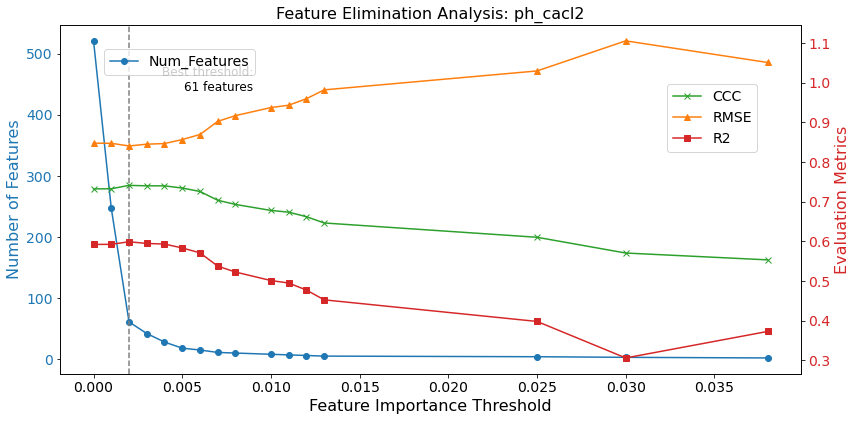

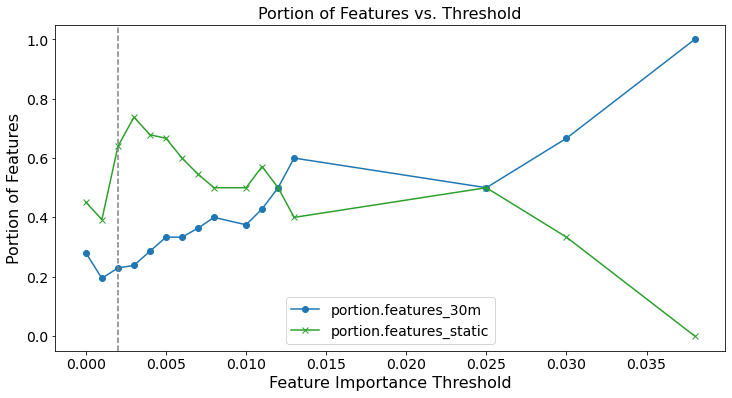

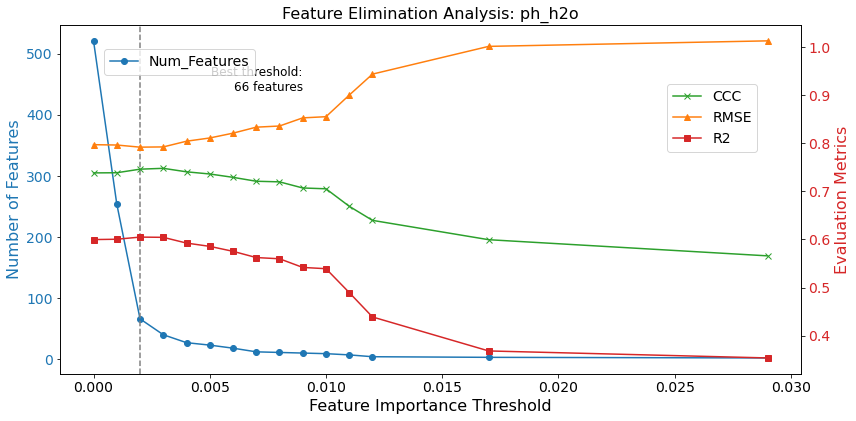

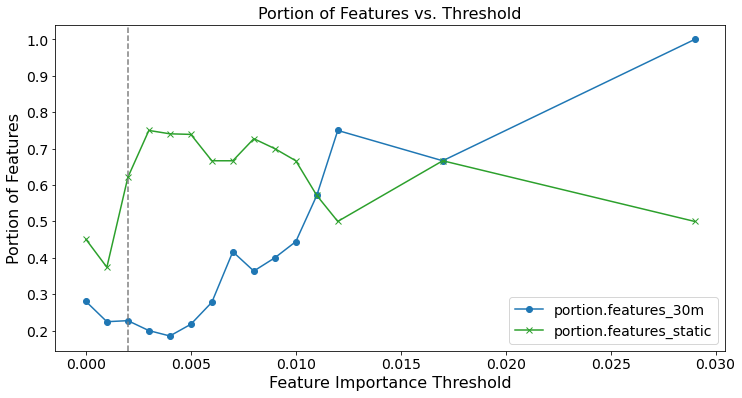

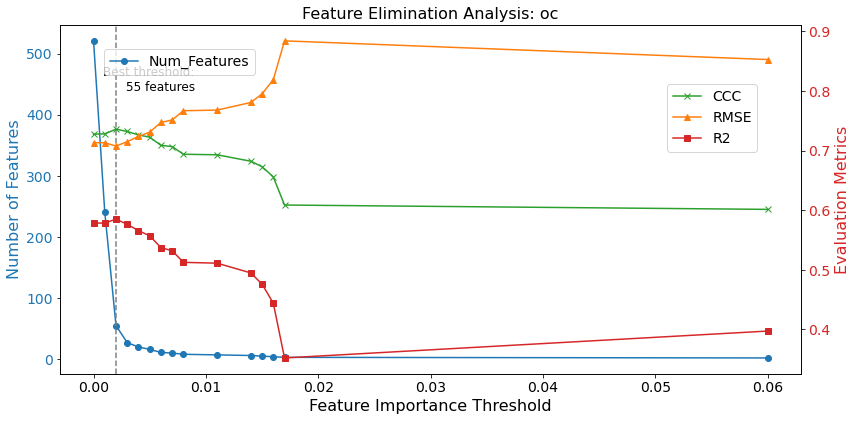

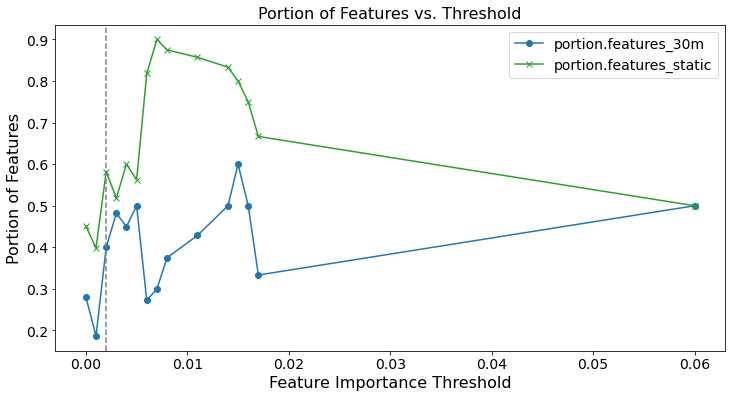

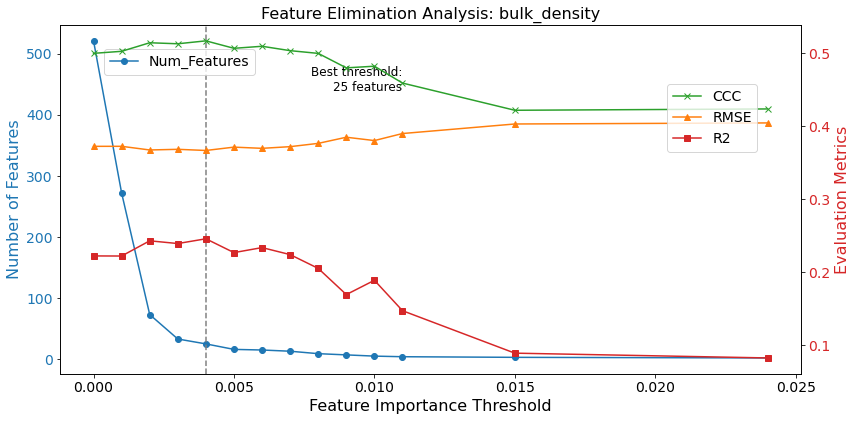

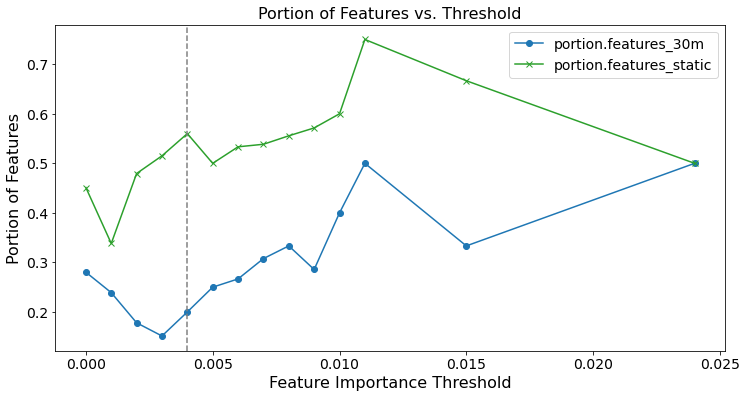

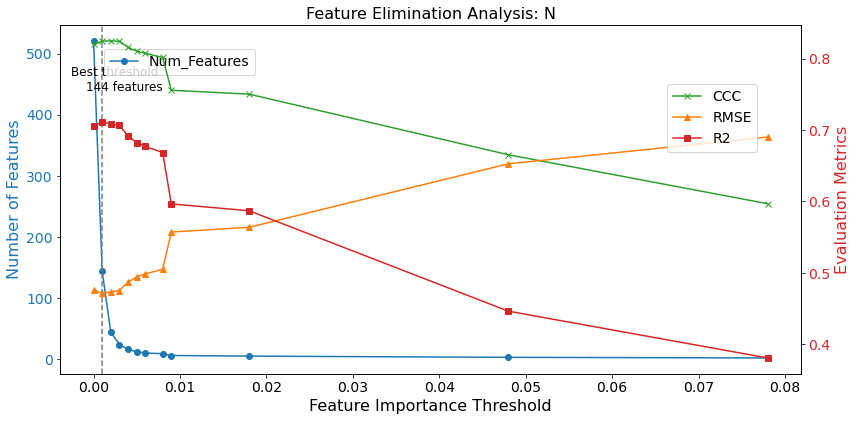

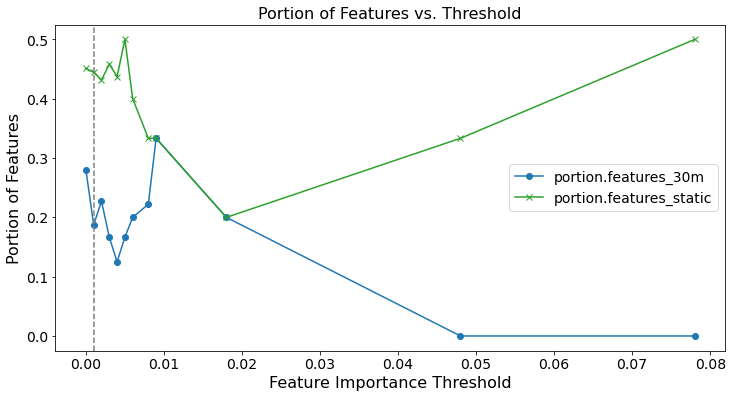

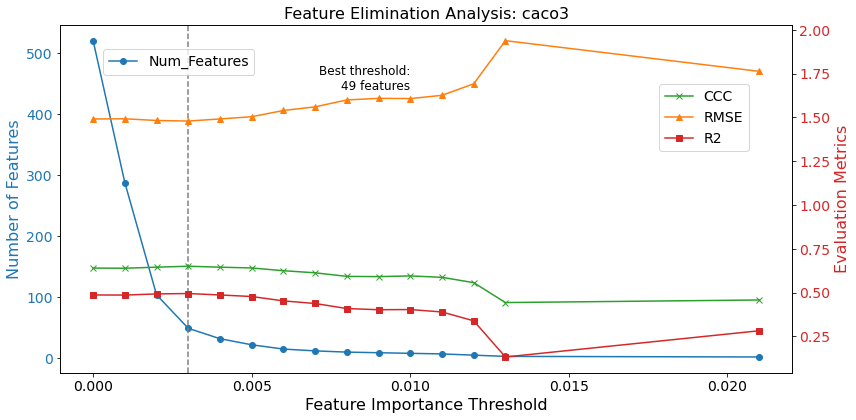

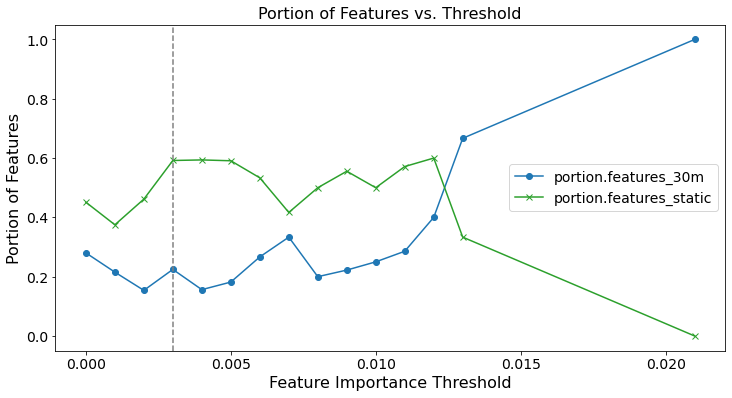

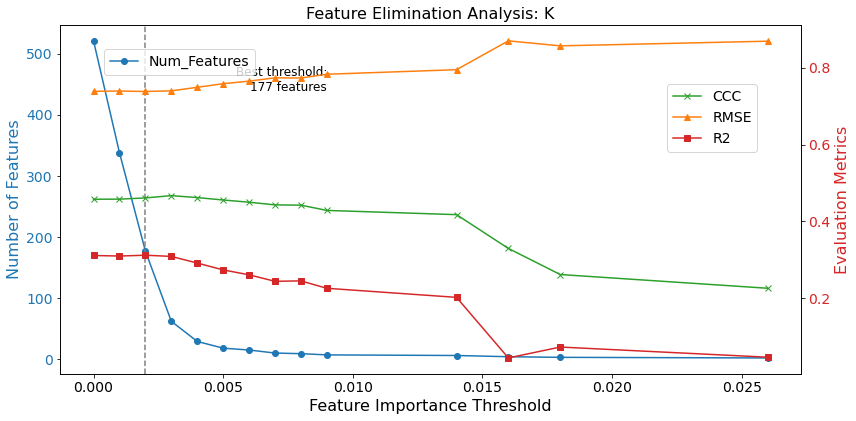

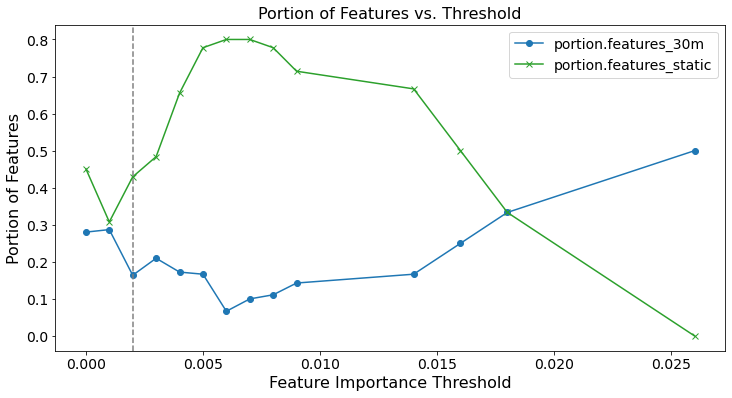

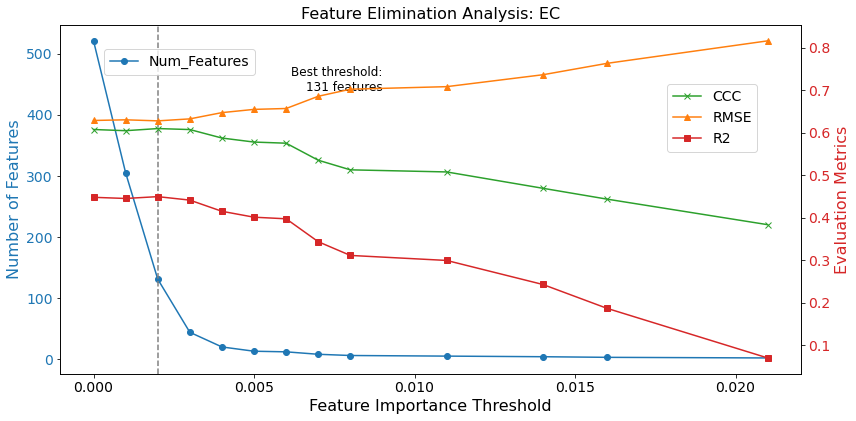

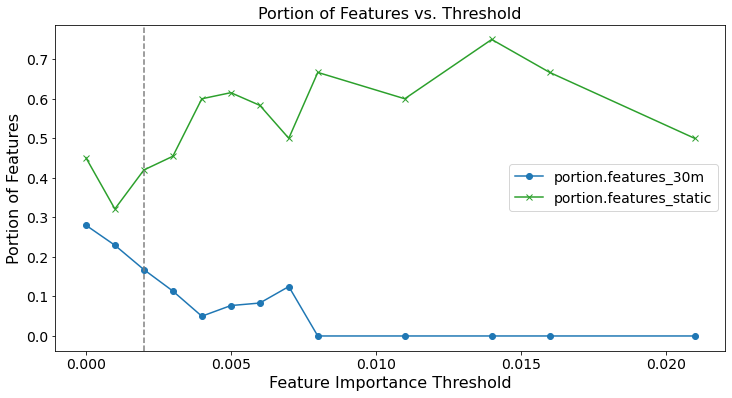

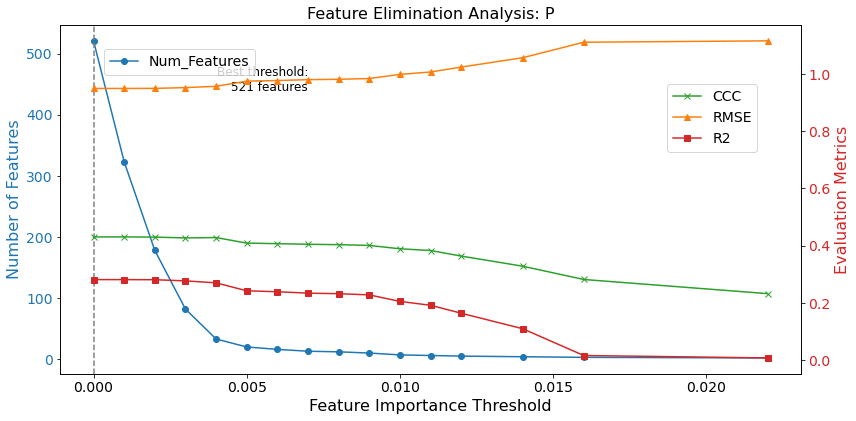

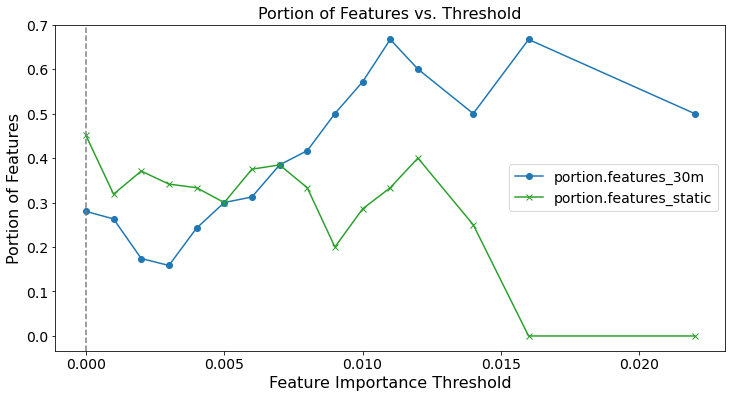

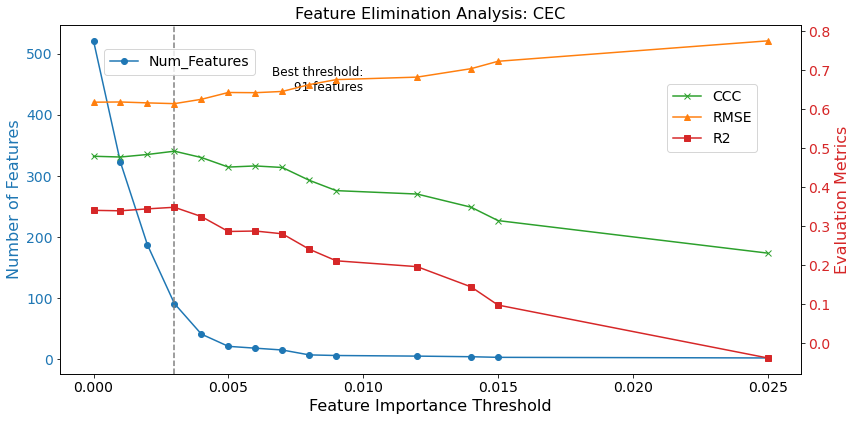

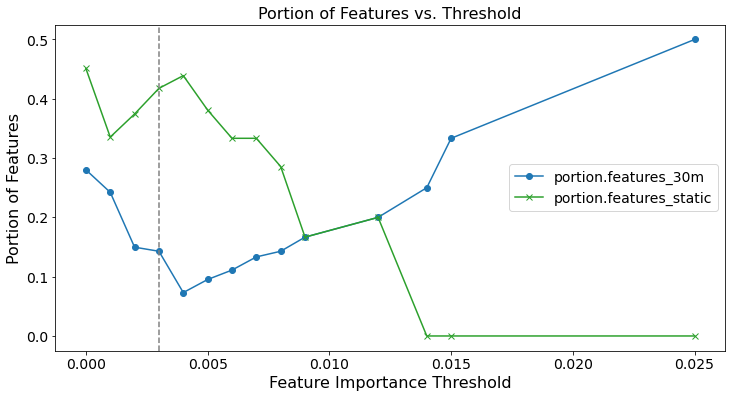

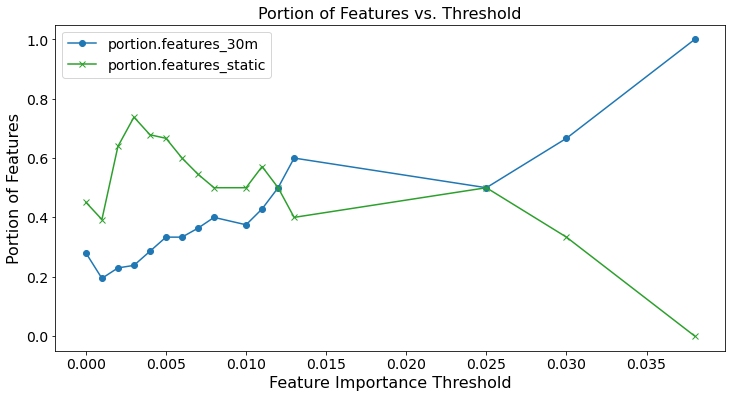

In [ ]:
max_threshold = cfi['Mean Cumulative Feature Importance'].max()
thresholds = np.arange(0, max_threshold + threshold_step, threshold_step)

In [18]:
for threshold in thresholds:
        current_features_df = sorted_importances[sorted_importances['Mean Cumulative Feature Importance'] >= threshold]
        current_features = current_features_df['Feature Name'].tolist()
        
        if set(current_features) == previous_feature_set:
            continue  # Skip if feature set doesn't change
        previous_feature_set = set(current_features)

        if len(current_features)<2:
            break  # Stop if limited (<2) features are left

        ttprint(f'processing {threshold} ...')
        rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
        group_kfold = GroupKFold(n_splits=n_splits)

        groups = data[spatial_cv_column].values
        y_pred = cross_val_predict(rf, data[current_features], data[tgt], cv=group_kfold, groups=groups, n_jobs=-1)
        y_true = data[tgt]

        metrics = calc_metrics(y_true, y_pred)
        results.append((threshold, len(current_features), *metrics))
        results_df = pd.DataFrame(results, columns=['Threshold', 'Num_Features', 'CCC', 'RMSE', 'R2'])

['hzn_dep']

In [56]:
l = 0
for key, value in tpr.items():
    l = len(value)+l
    
l

521

In [32]:
cfi.iloc[0]['Feature Name'].split('_')[6]

'{year}1231'

[]

In [55]:
len(tpr['stat)

{'static': ['pet.penman.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'vpd.mean_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'rsds.mean_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'bioclim.var_chelsa.bio18_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822',
  'lithology_EGDI_impureCarbonateSedimentaryRock',
  'clt_min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'hzn_dep',
  'bioclim.var_chelsa.bio15_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822',
  'rsds.min_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
  'lithology_EGDI_limestone',
  'pet.penman.mean_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'clt.mean_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
  'rsds.range_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531

In [16]:
time_series_counts = df.groupby('id')['time'].nunique()

# Count how many time series have more than two time steps
count_more_than_two_time_steps = (time_series_counts > 2).sum()
print(f"There are {count_more_than_two_time_steps} time series with more than two time steps.")

There are 1506 time series with more than two time steps.


In [11]:
df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/results/oc/benchmark_train.pnts_oc.csv')
df = df.dropna(subset=covs+['oc'],how='any')
df

/tmp/ipykernel_83015/1658307181.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/results/oc/benchmark_train.pnts_oc.csv')


,id,lat,lon,time,ref,nuts0,oc,ph_h2o,ph_cacl2,bulk_density,...,lithology_EGDI_tephrite,lithology_EGDI_tonalite,lithology_EGDI_trachyte,lithology_EGDI_trachytoid,lithology_EGDI_tuffBrecciaAgglomerateOrPyroclasticBreccia,lithology_EGDI_ultramaficIgneousRock,lithology_EGDI_wacke,lithology_EGDI_Unpopulated,hzn_dep,oc_log1p
0,1-1,40.871480,-7.049093,2000.0,portugal.infosolo,PT,6.7,5.2,NaN,NaN,...,0,0,0,0,0,0,0,0,15.0,2.041220
1,1-2,40.871480,-7.049093,2000.0,portugal.infosolo,PT,3.9,5.5,NaN,NaN,...,0,0,0,0,0,0,0,0,42.5,1.589235
2,2-3,40.583860,-6.952317,2000.0,portugal.infosolo,PT,5.9,4.9,NaN,NaN,...,0,0,0,0,0,0,0,0,6.5,1.931521
3,2-4,40.583860,-6.952317,2000.0,portugal.infosolo,PT,6.2,5.2,NaN,NaN,...,0,0,0,0,0,0,0,0,25.5,1.974081
4,4-7,40.416840,-7.027468,2000.0,portugal.infosolo,PT,10.5,5.3,NaN,NaN,...,0,0,0,0,0,0,0,0,12.5,2.442347
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81624,P0000739358,58.701308,26.593805,2021.0,estonia.kese,EE,20.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,10.0,3.044522
81625,P0000739254,58.701377,26.594116,2021.0,estonia.kese,EE,20.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,10.0,3.044522
81626,P0000739334,58.701446,26.594428,2021.0,estonia.kese,EE,20.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,10.0,3.044522
81627,P0000739268,58.936527,23.692333,2021.0,estonia.kese,EE,30.0,NaN,NaN,NaN,...,0,0,0,0,0,0,0,0,10.0,3.433987


In [5]:
models, model_names = parameter_fine_tuning(data, covs, tgt, output_folder)

NameError: name 'ccc_scorer' is not defined

### Rank frequency

In [4]:
from sklearn.ensemble import RandomForestRegressor
def run_rankcv(data, covs, tgt, spatial_cv_column, weights_feature=None, n_bootstrap=20, ntrees = 100):

    groups = data[spatial_cv_column].unique()
    runs = []
    feature_importances = []

    # loop on different bootstrap
    for k in range(n_bootstrap):
        
        np.random.seed(k)
        selected_groups = np.random.choice(groups, int(len(groups) * 0.7), False)  # each time cover 70% of the tiles
        train = data[data[spatial_cv_column].isin(selected_groups)]
        # train = samples_train.groupby(spatial_cv_column, group_keys=False).apply(lambda x: x.sample(min(len(x), 20)))  # make sure to select enough data for training
        
        ttprint(f'{k} iteration, training size: {len(train)}')
        # Get weights if applicable
        if weights_feature:
            weights = train[weights_feature].to_numpy()
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt], sample_weight=weights)
        else:
            rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
            rf.fit(train[covs], train[tgt])

        # importances = pd.Series(rf.feature_importances_, index=covs).sort_values(ascending=True)
        feature_importances.append(rf.feature_importances_)
#         importances = importances[importances>=importances.mean()]
#         runs.append((importances.index, np.array(importances.to_list())))
        
#     result = pd.DataFrame(
#         dict(feature=[feature for run in runs for feature in run[0]], 
#              importance=[importance for run in runs for importance in run[1]])
#     )
    return pd.DataFrame(feature_importances, columns=covs)
    # return result



    
result = run_rankcv(dff, covs, tgt, spatial_cv_column='tile_id')
# feature_list = result.groupby(['feature']).count().rename(columns=dict(importance='freq')).reset_index()

# features_freq = feature_list.groupby('freq').count().reset_index().sort_values(by='freq', ascending=False)
# features_freq['accum'] = features_freq['feature'].cumsum()
# features_freq

# print(feature_list.sort_values(by='freq', ascending=False).to_string())


[09:04:39] 0 iteration, training size: 14265
[09:05:24] 1 iteration, training size: 13783
[09:06:06] 2 iteration, training size: 13860
[09:06:49] 3 iteration, training size: 13918
[09:07:32] 4 iteration, training size: 13339
[09:08:15] 5 iteration, training size: 12896
[09:08:56] 6 iteration, training size: 13746
[09:09:39] 7 iteration, training size: 13695
[09:10:22] 8 iteration, training size: 13712
[09:11:05] 9 iteration, training size: 14073
[09:11:50] 10 iteration, training size: 14584
[09:12:36] 11 iteration, training size: 14160
[09:13:22] 12 iteration, training size: 13461
[09:14:05] 13 iteration, training size: 14249
[09:14:50] 14 iteration, training size: 14250
[09:15:35] 15 iteration, training size: 14473
[09:16:20] 16 iteration, training size: 14371
[09:17:07] 17 iteration, training size: 14033
[09:17:51] 18 iteration, training size: 14374
[09:18:39] 19 iteration, training size: 13333


In [12]:
sorted_importances = result.mean(axis=0).sort_values(ascending=False)
threshold_step = 0.001
print(f'start feature elimination evaluation...')
max_threshold = sorted_importances.max()
thresholds = np.arange(0, max_threshold + threshold_step, threshold_step)

start feature elimination evaluation...


In [24]:
previous_feature_set = set([])
ntrees = 100
n_splits = 5
data = dff.groupby('tile_id', group_keys=False).apply(lambda x: x.sample(n=max(1, int(np.ceil(0.1 * len(x))))))
spatial_cv_column='tile_id'
groups = data[spatial_cv_column].unique()
results = []
def evaluate_model(y_true, y_pred):
    ccc = calc_ccc(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return ccc, rmse, r2

for threshold in thresholds:
    current_features = sorted_importances[sorted_importances >= threshold].index.tolist()
    if set(current_features) == previous_feature_set:
        continue  # Skip if feature set doesn't change
    previous_feature_set = set(current_features)

    if len(current_features)<2:
        break  # Stop if limited (<2) features are left

    ttprint(f'processing {threshold} ...')
    rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
    group_kfold = GroupKFold(n_splits=n_splits)

    groups = data[spatial_cv_column].values
    y_pred = cross_val_predict(rf, data[current_features], data[tgt], cv=group_kfold, groups=groups, n_jobs=-1)
    y_true = data[tgt]

    metrics = evaluate_model(y_true, y_pred)
    results.append((threshold, len(current_features), *metrics))

results_df = pd.DataFrame(results, columns=['Threshold', 'Num_Features', 'CCC', 'RMSE', 'R2'])


[09:32:11] processing 0.0 ...
[09:32:34] processing 0.001 ...
[09:32:50] processing 0.002 ...
[09:32:53] processing 0.003 ...
[09:32:55] processing 0.004 ...
[09:32:56] processing 0.005 ...
[09:32:57] processing 0.006 ...
[09:32:58] processing 0.007 ...
[09:32:59] processing 0.008 ...
[09:32:59] processing 0.011 ...
[09:33:00] processing 0.014 ...
[09:33:00] processing 0.015 ...
[09:33:01] processing 0.016 ...
[09:33:01] processing 0.017 ...
[09:33:02] processing 0.06 ...


In [27]:
results_df['CCC_Rank'] = results_df['CCC'].rank(ascending=False)
results_df['RMSE_Rank'] = results_df['RMSE'].rank(ascending=True)
results_df['R2_Rank'] = results_df['R2'].rank(ascending=False)
results_df['Combined_Rank'] = results_df['CCC_Rank'] + results_df['RMSE_Rank'] + results_df['R2_Rank']
results_df = results_df.sort_values(by='Combined_Rank')

best_threshold = None

for index, row in results_df.iterrows():
    if row['Num_Features'] < 90:
        best_threshold = row['Threshold']
        break

,Threshold,Num_Features,CCC,RMSE,R2,CCC_Rank,RMSE_Rank,R2_Rank,Combined_Rank
2,0.002,55,0.710933,0.719021,0.553928,1.0,1.0,1.0,3.0
3,0.003,27,0.704213,0.729731,0.540540,2.0,2.0,2.0,6.0
0,0.000,521,0.690828,0.733438,0.535860,6.0,3.0,3.0,12.0
1,0.001,241,0.691778,0.733783,0.535424,5.0,4.0,4.0,13.0
4,0.004,20,0.699822,0.738292,0.529697,3.0,5.0,5.0,13.0
5,0.005,16,0.698816,0.741530,0.525562,4.0,6.0,6.0,16.0
9,0.011,7,0.688000,0.755414,0.507630,7.0,7.0,7.0,21.0
7,0.007,10,0.687001,0.756040,0.506813,8.0,8.0,8.0,24.0
8,0.008,8,0.686345,0.757445,0.504978,9.0,9.0,9.0,27.0
6,0.006,11,0.684556,0.757453,0.504967,12.0,10.0,10.0,32.0


In [33]:
        
best_threshold

0.002

In [38]:
optimal_feature = sorted_importances[sorted_importances >= best_threshold].index.tolist()

optimal_feature

['hzn_dep',
 'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'bioclim.var_chelsa.bio10_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822',
 'dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424',
 'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
 'vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'ai_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
 'dtm.bareearth_ensemble_p10_60m_s_20000101_20221231_eu_epsg.3035_v20240424',
 'nosink.bareearth_ensemble_m_60m_s_20000101_20221231_eu_epsg.3035_v20240501',
 'lithology_EGDI_peat',
 'wv_mcd19a2v061.seasconv.m.yearly_p75_1km_s_{year}0101_{year}1231_eu_epsg.3035_v20230619',
 'ndti_glad.landast.ard2.seasconv.m.yearly_p50_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'thermal_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
 'accum.ndti_glad.landsat.sea

In [ ]:
results_df['CCC_Rank'] = results_df['CCC'].rank(ascending=False)
results_df['RMSE_Rank'] = results_df['RMSE'].rank(ascending=True)
results_df['R2_Rank'] = results_df['R2'].rank(ascending=False)

# Summing up the ranks to get a combined rank
results_df['Combined_Rank'] = results_df['CCC_Rank'] + results_df['RMSE_Rank'] + results_df['R2_Rank']

# Finding the best threshold (the one with the lowest combined rank)
best_threshold_row = results_df.loc[results_df['Combined_Rank'].idxmin()]


In [2]:
def find_knee_point(importances):
    x = np.arange(len(importances))
    kneedle = KneeLocator(x, importances, curve='convex', direction='decreasing')
    knee_index = kneedle.knee
    return knee_index

sorted_accumu_importance = result.mean(axis=0).sort_values(ascending=False)
knee_index = find_knee_point(sorted_accumu_importance.values)

# Extract features before the knee point
features_before_knee = sorted_accumu_importance.index[:knee_index+1]  # Include the knee itself

# Save to text file
with open('important_features.txt', 'w') as file:
    for feature in features_before_knee:
        file.write(f"{feature}\n")

NameError: name 'result' is not defined

In [10]:
sorted_accumu_importance['dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424']

0.0070448421341513705

In [11]:
sorted_accumu_importance.iloc[0:9]

hzn_dep                                                                                               0.208949
ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127       0.156156
bioclim.var_chelsa.bio10_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822                             0.039007
nosink.bareearth_ensemble_m_60m_s_20000101_20221231_eu_epsg.3035_v20240501                            0.017155
ai_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531                                            0.013132
vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531                                       0.012543
ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127           0.011957
thermal_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127    0.007563
dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424                             0.007045
d

In [8]:
sorted_accumu_importance.index[:knee_index+1]

Index(['hzn_dep',
       'ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
       'bioclim.var_chelsa.bio10_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822',
       'nosink.bareearth_ensemble_m_60m_s_20000101_20221231_eu_epsg.3035_v20240501',
       'ai_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
       'vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531',
       'ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127',
       'thermal_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127',
       'dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424'],
      dtype='object')

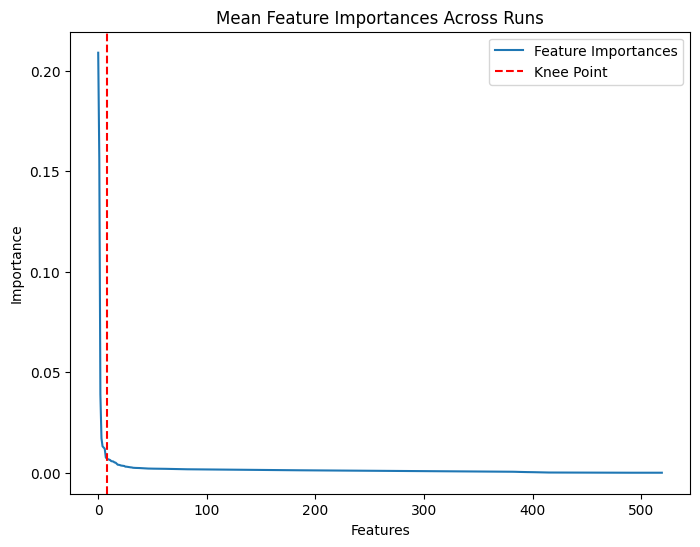

In [7]:
plt.figure(figsize=(8, 6))
plt.plot(np.arange(0, len(sorted_accumu_importance)), sorted_accumu_importance.values, label='Feature Importances')
plt.axvline(x=knee_index, color='r', linestyle='--', label='Knee Point')
plt.title('Mean Feature Importances Across Runs')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.legend()
plt.show()

### feature elimination

In [25]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import pearsonr
from sklearn.model_selection import GroupKFold, cross_val_predict


def evaluate_model(y_true, y_pred):
    ccc = calc_ccc(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred, squared=False)
    r2 = r2_score(y_true, y_pred)
    return ccc, rmse, r2

def feature_elimination_analysis(data, covs, tgt, sorted_importances, spatial_cv_column, threshold_step=0.001, max_threshold=0.2, ntrees=100, n_splits=5):
    results = []
    thresholds = np.arange(0, max_threshold + threshold_step, threshold_step)
    previous_feature_set = set([])

    for threshold in thresholds:
        current_features = sorted_importances[sorted_importances >= threshold].index.tolist()
        if set(current_features) == previous_feature_set:
            continue  # Skip if feature set doesn't change
        previous_feature_set = set(current_features)

        if not current_features:
            break  # Stop if no features are left
        
        ttprint(f'processing {threshold} ...')
        rf = RandomForestRegressor(random_state=41, n_jobs=80, n_estimators=ntrees)
        group_kfold = GroupKFold(n_splits=n_splits)
        
        groups = data[spatial_cv_column].values
        y_pred = cross_val_predict(rf, data[current_features], data[tgt], cv=group_kfold, groups=groups, n_jobs=-1)
        y_true = data[tgt]

        metrics = evaluate_model(y_true, y_pred)
        results.append((threshold, len(current_features), *metrics))


    results_df = pd.DataFrame(results, columns=['Threshold', 'Num_Features', 'CCC', 'RMSE', 'R2'])
    return results_df


results_df = feature_elimination_analysis(dff, covs, tgt, sorted_accumu_importance, spatial_cv_column='tile_id')

# import ace_tools as tools; tools.display_dataframe_to_user(name="Feature Elimination Analysis Results", dataframe=results_df)


[09:15:32] processing 0.0 ...
[09:16:46] processing 0.001 ...
[09:17:37] processing 0.002 ...
[09:17:48] processing 0.003 ...
[09:17:53] processing 0.004 ...
[09:17:57] processing 0.005 ...
[09:18:00] processing 0.006 ...
[09:18:03] processing 0.007 ...
[09:18:05] processing 0.008 ...
[09:18:07] processing 0.012 ...
[09:18:08] processing 0.013000000000000001 ...
[09:18:10] processing 0.014 ...
[09:18:11] processing 0.018000000000000002 ...
[09:18:12] processing 0.04 ...
[09:18:12] processing 0.157 ...


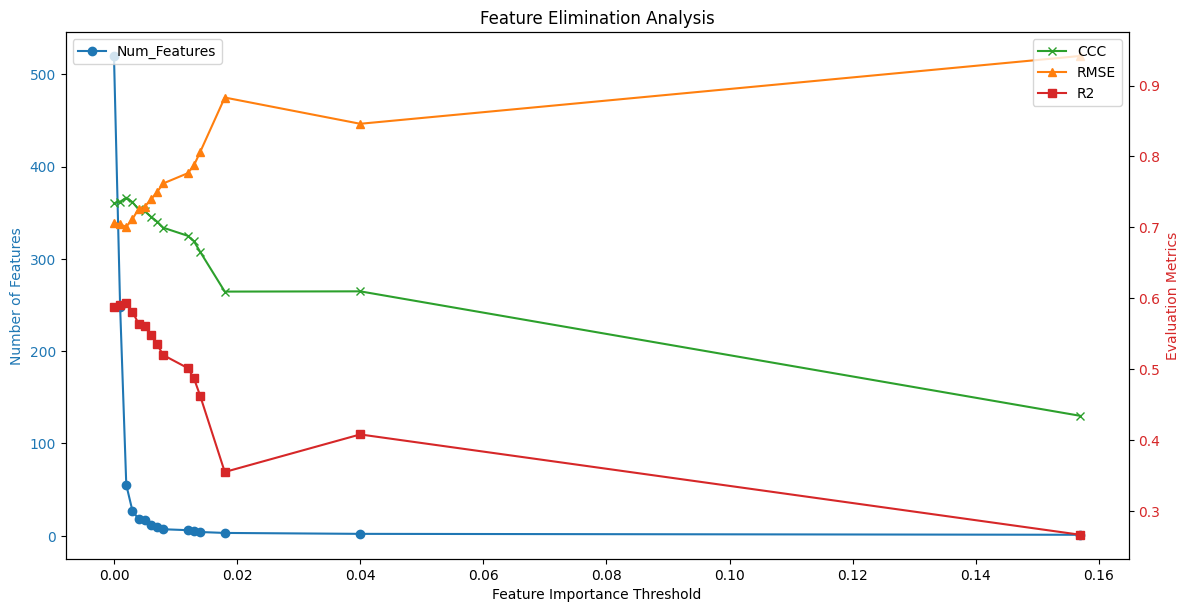

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_results(results_df):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot number of features remaining as a function of the threshold
    color = 'tab:blue'
    ax1.set_xlabel('Feature Importance Threshold')
    ax1.set_ylabel('Number of Features', color=color)
    ax1.plot(results_df['Threshold'], results_df['Num_Features'], color=color, marker='o', label='Num_Features')
    ax1.tick_params(axis='y', labelcolor=color)

    # Create a second y-axis to plot the evaluation metrics
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Evaluation Metrics', color=color)
    ax2.plot(results_df['Threshold'], results_df['CCC'], color='tab:green', marker='x', label='CCC')
    ax2.plot(results_df['Threshold'], results_df['RMSE'], color='tab:orange', marker='^', label='RMSE')
    ax2.plot(results_df['Threshold'], results_df['R2'], color='tab:red', marker='s', label='R2')
    ax2.tick_params(axis='y', labelcolor=color)

    # Add legends
    fig.tight_layout()  # Ensure the plot fits well
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title('Feature Elimination Analysis')
    plt.show()

# Assuming `results_df` is already defined from the feature elimination analysis
plot_results(results_df)


In [59]:
sorted_accumu_importance.to_csv('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/cumulative_feature_importance.csv')

In [4]:
a = pd.read_csv('/home/opengeohub/xuemeng/work_xuemeng/soc/result_paper/cumulative_feature_importance.csv')

In [6]:
a.max()

Unnamed: 0    wv_mcd19a2v061.seasconv_sd_1km_s_{year}1201_{y...
0                                                      0.208949
dtype: object

In [36]:
optimal_feature = sorted_accumu_importance[sorted_accumu_importance >= 0.002].index.tolist()
with open('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_optimal', 'w') as file:
    for feature in optimal_feature:
        file.write(f"{feature}\n")
        
        
sorted_accumu_importance[sorted_accumu_importance >= 0.002]


hzn_dep                                                                                                  0.208949
ndti_glad.landast.ard2.seasconv.m.yearly_p25_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127          0.156156
bioclim.var_chelsa.bio10_m_1km_s_19810101_20101231_eu_epsg.3035_v20230822                                0.039007
nosink.bareearth_ensemble_m_60m_s_20000101_20221231_eu_epsg.3035_v20240501                               0.017155
ai_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531                                               0.013132
vpd.max_chelsa_m_1km_s_19810101_20101231_eu_epsg.3035_v20240531                                          0.012543
ndvi_glad.landsat.ard2.seasconv.longterm_p25_30m_s_20000101_20221231_eu_epsg.3035_v20231127              0.011957
thermal_glad.landsat.ard2.seasconv.m.yearly_p75_30m_s_{year}0101_{year}1231_eu_epsg.3035_v20231127       0.007563
dtm.bareearth_ensemble_p10_30m_s_20000101_20221231_eu_epsg.3035_v20240424               

### parameter fine-tuning

In [2]:
covs = read_features('/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_optimal.txt')

### parameter fine tuning
spatial_cv_column = 'tile_id'
cv = GroupKFold(n_splits=5)
fitting_score = ccc_scorer
## no weights version
# random forest
param_rf = {
    'n_estimators': [60, 80, 100],
    "criterion": [ 'squared_error', 'absolute_error', 'poisson', 'friedman_mse'],
    'max_depth': [10, 20, 30],
    'max_features': [0.3, 0.5, 0.7, 'log2', 'sqrt'],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tune_rf = HalvingGridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=param_rf,
    scoring=fitting_score,
    n_jobs=90, 
    cv=cv,
    verbose=1,
    random_state = 1992
)


tune_rf.fit(dff[covs], dff[tgt], groups=dff[spatial_cv_column])
warnings.filterwarnings('ignore')
rf = tune_rf.best_estimator_
joblib.dump(rf, f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/model_rf.{prop}_log1p.ccc.joblib')



n_iterations: 7
n_required_iterations: 7
n_possible_iterations: 7
min_resources_: 27
max_resources_: 19784
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 1620
n_resources: 27
Fitting 5 folds for each of 1620 candidates, totalling 8100 fits
----------
iter: 1
n_candidates: 540
n_resources: 81
Fitting 5 folds for each of 540 candidates, totalling 2700 fits
----------
iter: 2
n_candidates: 180
n_resources: 243
Fitting 5 folds for each of 180 candidates, totalling 900 fits
----------
iter: 3
n_candidates: 60
n_resources: 729
Fitting 5 folds for each of 60 candidates, totalling 300 fits
----------
iter: 4
n_candidates: 20
n_resources: 2187
Fitting 5 folds for each of 20 candidates, totalling 100 fits
----------
iter: 5
n_candidates: 7
n_resources: 6561
Fitting 5 folds for each of 7 candidates, totalling 35 fits
----------
iter: 6
n_candidates: 3
n_resources: 19683
Fitting 5 folds for each of 3 candidates, totalling 15 fits


['/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/model_rf.oc_log1p.ccc.joblib']

### acccuracy examination

In [5]:
train = pd.read_csv(f'{folder}/benchmark_train.pnts_{prop}.csv',low_memory=False)
test = pd.read_csv(f'{folder}/benchmark_test.pnts_{prop}.csv',low_memory=False)

train = train.dropna(subset=covs,how='any')
test = test.dropna(subset=covs,how='any')

optimal_feature = read_features(f'/mnt/primus/xuemeng_tmp_harbour/soc/result_paper/feature_optimal.txt')

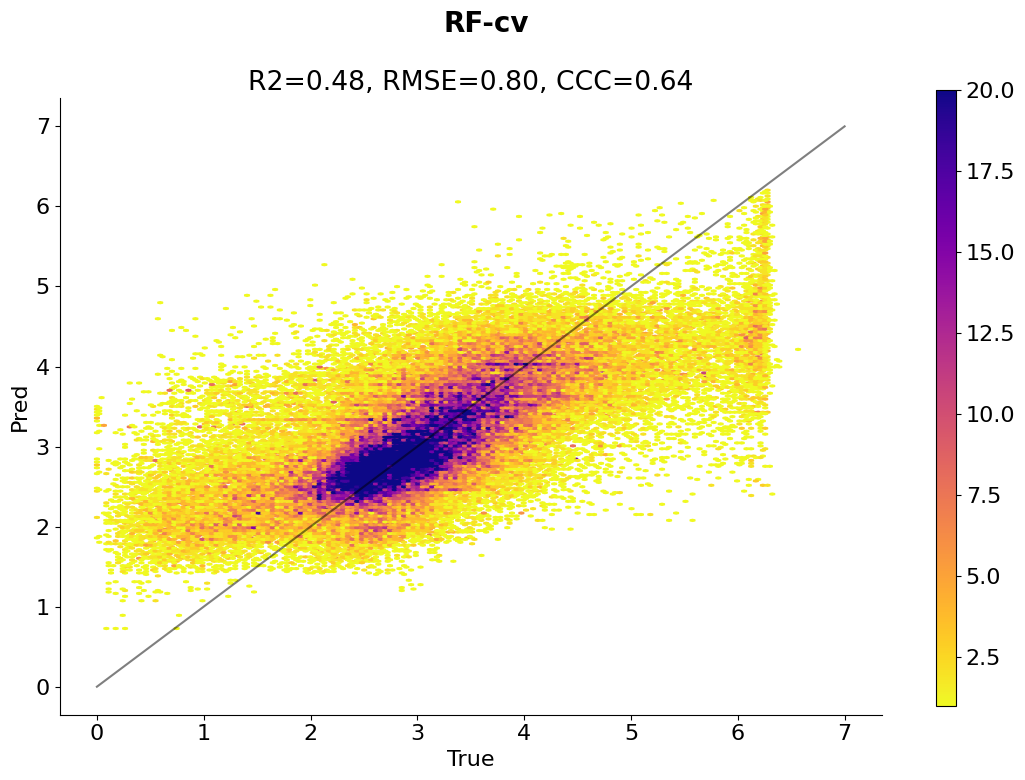

In [6]:
import math
show_low = math.floor(train[tgt].min())
show_high = math.ceil(train[tgt].max())

y_pred = cross_val_predict(rf, train[optimal_feature], train[tgt], cv=cv, groups=train[spatial_cv_column], n_jobs=-1)
y_true = train[tgt]

from benchmark_pipeline import accuracy_plot
r2_cv, rmse_cv, ccc_cv = accuracy_plot(y_true, y_pred, 'RF-cv', 
                                       output_folder='/mnt/primus/xuemeng_tmp_harbour/soc/result_paper', 
                                       show_range = [show_low, show_high], vmax=20) # visuliazation

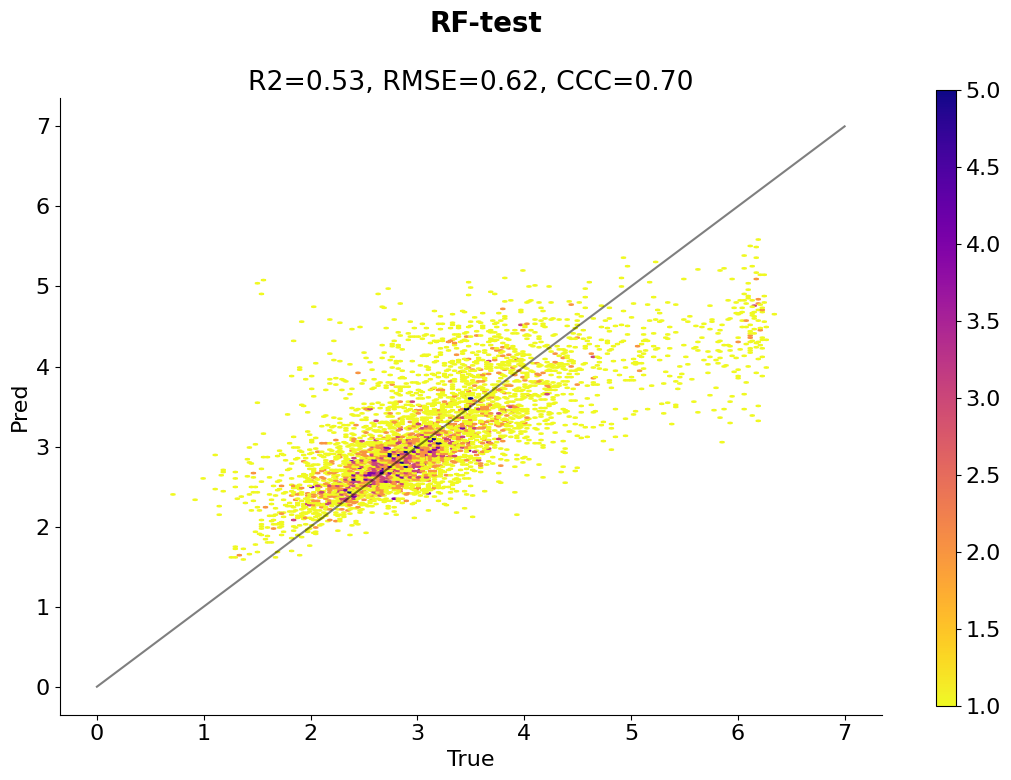

In [7]:
show_low = math.floor(test[tgt].min())
show_high = math.ceil(test[tgt].max())
rf.n_jobs = 90
rf.fit(train[covs], train[tgt])
y_pred = rf.predict(test[covs])
y_true = test[tgt]
r2_val, rmse_val, ccc_val = accuracy_plot(y_true, y_pred, 'RF-test', 
                                          output_folder='/mnt/primus/xuemeng_tmp_harbour/soc/result_paper',
                                          show_range = [show_low, show_high], vmax=5) # visuliazation